{'dx': 219, 'dy': 207, 'x0': 209, 'y0': 139}
(5589,)
49.0
steps -90.0 aligned: False
G10 L20 P1 Y0
G1 Y-90 F20000



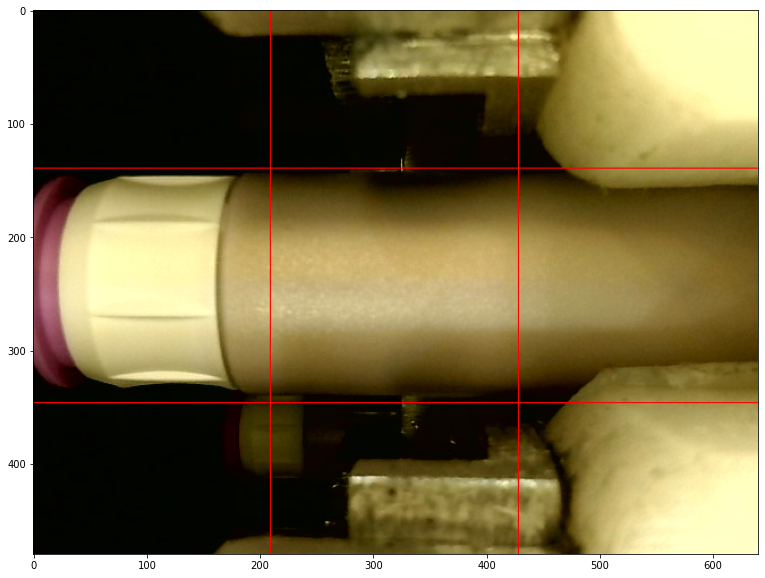

In [15]:
import json
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
import sklearn
from clean_for_training import prepare_frame


def load_data():
    with open('annotaion.json') as f:
        data = json.loads(f.read())
    return data

node = '108'
component = 'dosing'

data = load_data()
roi = data[node][component + '_roi']
print(roi)
''' show image '''
img_org = cv2.imread('../dump/%s_192.168.44.%s.png' % (component, node))
img = img_org.copy()[:,:,::-1]
img[roi['y0'],:] = [255,0,0]
img[roi['y0']+roi['dy'],:] = [255,0,0]
img[:,roi['x0']] = [255,0,0]
img[:,roi['x0']+roi['dx']] = [255,0,0]

plt.figure(figsize=(18, 10))
plt.imshow(img)


clf = pickle.load(open('../../models/%s_%s.clf'%(component, node), 'rb'))
back_cross_section = pickle.load(open(f'../../models/cross_section_{node}.pickle', 'rb'))
frame = prepare_frame(img_org, roi, component, back_cross_section)

print(frame.shape)
cls = clf.predict([frame])[0]
print(cls)


step_per_rev = 360
class_per_rev = 100
p = 1.0 / class_per_rev * step_per_rev
cls = cls-2
if cls <= 0:
    cls = -cls
elif cls <= 33:
    cls = class_per_rev - cls
else:
    cls = 25

steps = -cls * p
aligned = bool(abs(cls) < 3)  # np.bool_ to bool
print('steps', steps, 'aligned:', aligned)

axis = {'holder': 'X', 'dosing': 'Y'}[component]
command = ''
command += 'G10 L20 P1 %s0\n' % axis
command += 'G1 %s%d F20000\n' % (axis, steps)
print(command)

In [3]:
frame = cv2.imread('../dump/data/a.png')
print(frame.shape)
plt.imshow(frame)

def prepare_frame(frame, component):
    if component == 'dosing':
        x_downsample = 8
        y_downsample = 2
    elif component == 'holder':
        x_downsample = 2
        y_downsample = 8
    else:
        raise

    x_size = round(frame.shape[1] / x_downsample)
    y_size = round(frame.shape[0] / y_downsample)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame = cv2.resize(frame, (x_size, y_size), interpolation=cv2.INTER_AREA)

    frame = frame.flatten()
    return frame

def prepare_frame2(frame, component):
    if component == 'dosing':
        x_downsample = 8
        y_downsample = 2
    elif component == 'holder':
        x_downsample = 2
        y_downsample = 8
    else:
        raise

    x0 = roi['x0']
    x1 = roi['x0'] + roi['dx']
    y0 = roi['y0']
    y1 = roi['y0'] + roi['dy']
    x_size = round(frame.shape[1] / x_downsample)
    y_size = round(frame.shape[0] / y_downsample)

    #frame = frame[y0:y1, x0:x1, :]
    print(frame.shape)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (x_size, y_size), interpolation=cv2.INTER_AREA)
    print(frame.shape)

    # plt.imshow(frame)
    # plt.show()
    # raise

    frame = frame.flatten()
    return frame

frame = prepare_frame2(frame, component)
cls = clf.predict([frame])[0]
print(cls)

AttributeError: 'NoneType' object has no attribute 'shape'

-28.0


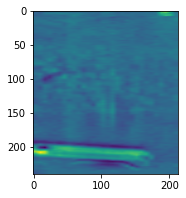

-27.0


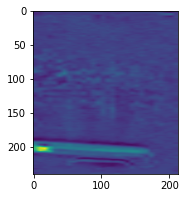

-26.0


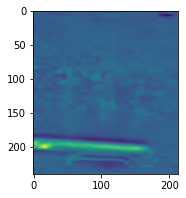

-25.0


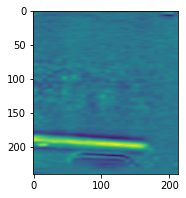

-24.0


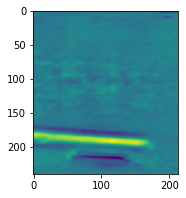

-23.0


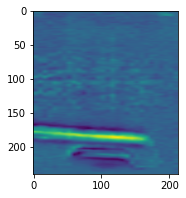

-22.0


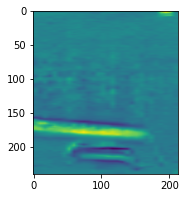

-21.0


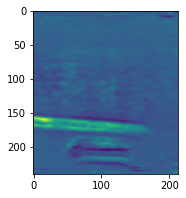

-20.0


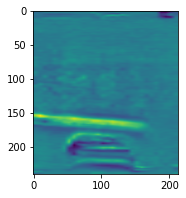

-19.0


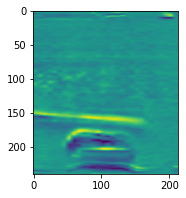

-18.0


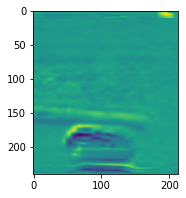

-17.0


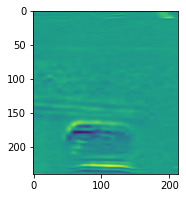

-16.0


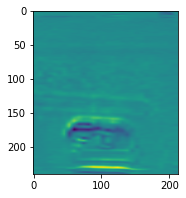

-15.0


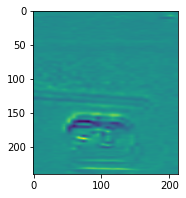

-14.0


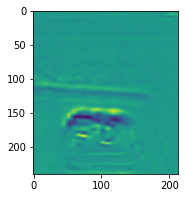

-13.0


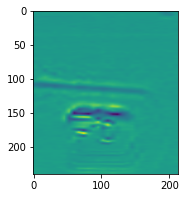

-12.0


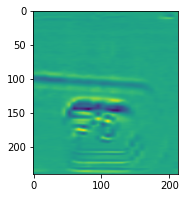

-11.0


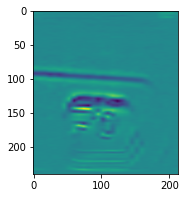

-10.0


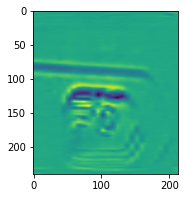

-9.0


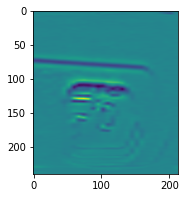

-8.0


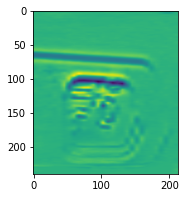

-7.0


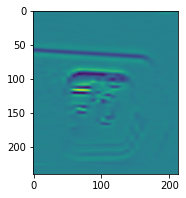

-6.0


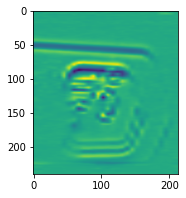

-5.0


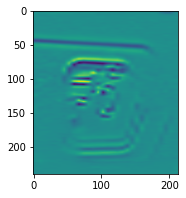

-4.0


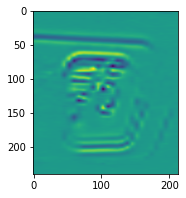

-3.0


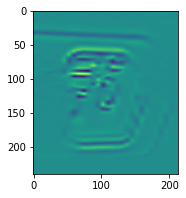

-2.0


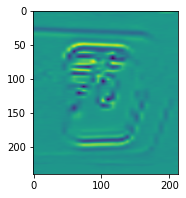

-1.0


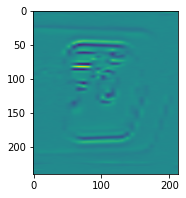

0.0


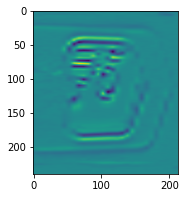

1.0


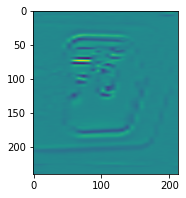

2.0


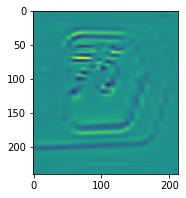

3.0


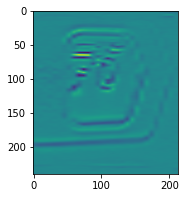

4.0


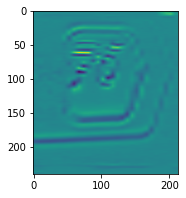

5.0


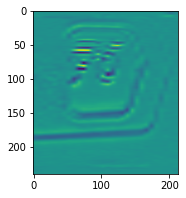

6.0


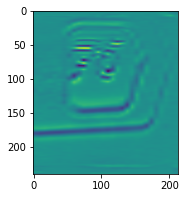

7.0


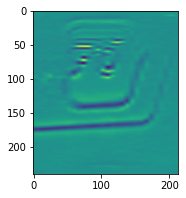

8.0


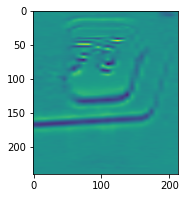

9.0


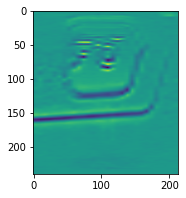

10.0


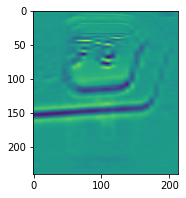

11.0


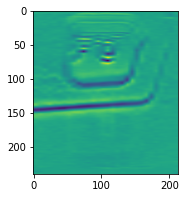

12.0


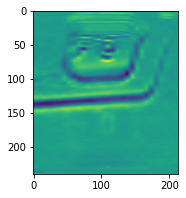

13.0


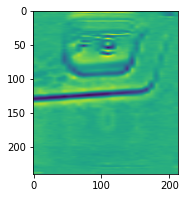

14.0


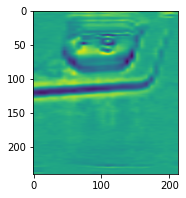

15.0


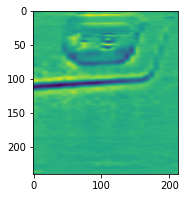

16.0


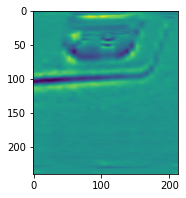

17.0


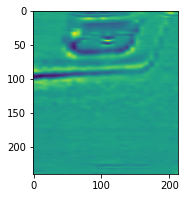

18.0


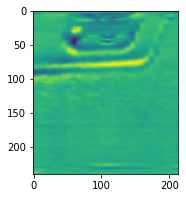

19.0


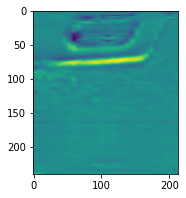

20.0


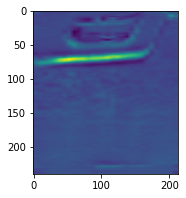

21.0


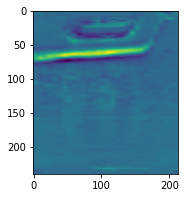

22.0


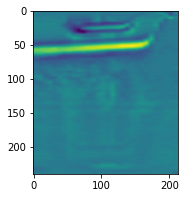

23.0


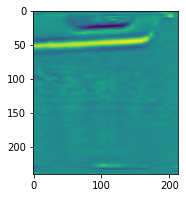

24.0


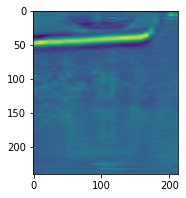

25.0


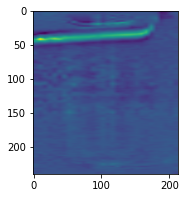

26.0


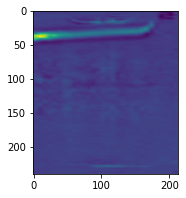

27.0


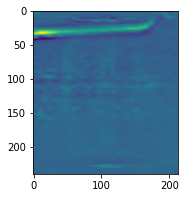

28.0


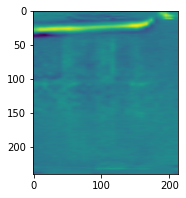

49.0


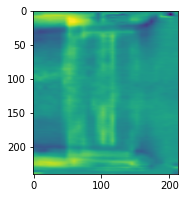

In [13]:
coefs = np.array([j.base_estimator.coef_ for j in clf.calibrated_classifiers_]).mean(axis=0)
coefs = coefs.reshape(coefs.shape[0], roi['dy'], -1)

for i in range(coefs.shape[0]):
    c = coefs[i]
    c = cv2.resize(c, [c.shape[0], c.shape[1]*8])
    a = plt.figure(i)
    print(clf.classes_[i])
    plt.imshow(c)
    a.set_size_inches(5, 3, forward=True)

    plt.show()


In [21]:
classes = clf.classes_[:]
classes.sort()
classes


array([-17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  49.])

In [32]:
CPR = 80
y = np.arange(400)/400 * CPR
print(y)

y = y.round().astype(int)
print(y)

y = np.mod(y + int(CPR / 2), CPR) - int(CPR / 2)
print(y)

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.2 31.4 31.6 31.8 32.  32.2 32.4 32.6 32.8 33.  33.2 33.4
 33.6 33.8 34.  34.2 34.4 34.6 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2
 36.4 36.6 36.8 37.  37.2 37.4 37.6 37.8 38.  38.2 38.4 38.6 38.8 39.
 39.2 39.